
\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# 1. {-}

## 1.1 {-}

In [1]:
import pandas as pd
from sklearn.preprocessing import Normalizer

stock = pd.read_csv('stocksample.txt', sep='\t', index_col='symb')
stock = stock[stock.columns[3:]]
stock = (stock - stock.mean())/stock.std()

stock.describe()[1:3]

,2017-08-18,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-28,2017-08-29,2017-08-30,2017-08-31,...,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29
mean,5.853096e-16,-4.405365e-16,3.872458e-16,3.907985e-16,2.939871e-16,-1.421085e-16,2.167155e-16,-5.684342e-17,6.661338e-16,-2.104983e-16,...,6.501466e-16,1.296740e-15,1.962874e-16,-9.832135e-16,-1.438849e-16,-2.113865e-16,-9.379164e-16,-1.687539e-16,-1.350031e-16,6.172840e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


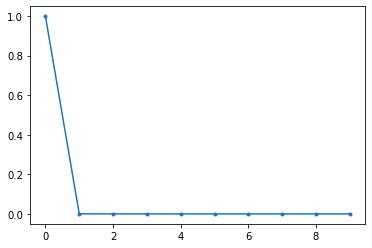

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas import Series

pcaout = PCA(n_components=10).fit(stock)
Series(pcaout.explained_variance_ratio_).plot(style='.-')
plt.show()

In [5]:
import numpy as np

np.set_printoptions(suppress=True)
pcaout.explained_variance_ratio_

array([0.99908156, 0.00067713, 0.00009899, 0.00003843, 0.00002885,
       0.00001448, 0.00001075, 0.00000848, 0.00000702, 0.00000663])